<h1>Sentiment Analysis project<h1>
<h3>Name student: Jorge Emilio Vasquez<h3>
<h3>Student ID: 300359443<h3>


In [1]:
!pip install nltk pandas numpy wordcloud matplotlib scikit-learn tensorflow keras


In [2]:
# Import required libraries
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, SpatialDropout1D, LSTM, Dense
from keras.utils import to_categorical
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split


In [3]:
# Load the dataset
data = pd.read_csv("customer_review.tsv", sep="\t", encoding="iso-8859-1")

# Display the first 10 rows of the dataset
print(data.head(10))


   ï»¿rating       date             variation  \
0          5  31-Jul-18      Charcoal Fabric    
1          5  31-Jul-18      Charcoal Fabric    
2          4  31-Jul-18        Walnut Finish    
3          5  31-Jul-18      Charcoal Fabric    
4          5  31-Jul-18      Charcoal Fabric    
5          5  31-Jul-18  Heather Gray Fabric    
6          3  31-Jul-18     Sandstone Fabric    
7          5  31-Jul-18      Charcoal Fabric    
8          5  30-Jul-18  Heather Gray Fabric    
9          5  30-Jul-18  Heather Gray Fabric    

                                    verified_reviews  feedback  
0                                      Love my Echo!         1  
1                                          Loved it!         1  
2  Sometimes while playing a game, you can answer...         1  
3  I have had a lot of fun with this thing. My 4 ...         1  
4                                              Music         1  
5  I received the echo as a gift. I needed anothe...         1  
6  Wi

In [8]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')  # Download stopwords if you haven't already

def clean_text(text):
    stopwords_list = set(stopwords.words("english"))
    # Lowercase text
    text = text.lower()
    # Remove numbers and special characters
    text = ''.join([char if char.isalnum() or char.isspace() else ' ' for char in text])
    # Remove stopwords
    text = ' '.join([word for word in text.split() if word not in stopwords_list])
    return text

# Call the function with a test string
test_string = "This is a test string with some punctuation and stopwords."
cleaned_string = clean_text(test_string)
print(cleaned_string)  # Should print the cleaned string


test string punctuation stopwords


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [9]:
# Check for missing values
print("Missing values per column:\n", data.isnull().sum())


Missing values per column:
 ï»¿rating           0
date                0
variation           0
verified_reviews    1
feedback            0
dtype: int64


In [10]:
# Rename columns if needed
data = data.rename(columns={"old_name1": "new_name1", "old_name2": "new_name2"})
print(data.columns)
print(data.head())


Index(['ï»¿rating', 'date', 'variation', 'verified_reviews', 'feedback'], dtype='object')
   ï»¿rating       date         variation  \
0          5  31-Jul-18  Charcoal Fabric    
1          5  31-Jul-18  Charcoal Fabric    
2          4  31-Jul-18    Walnut Finish    
3          5  31-Jul-18  Charcoal Fabric    
4          5  31-Jul-18  Charcoal Fabric    

                                    verified_reviews  feedback  
0                                      Love my Echo!         1  
1                                          Loved it!         1  
2  Sometimes while playing a game, you can answer...         1  
3  I have had a lot of fun with this thing. My 4 ...         1  
4                                              Music         1  


In [11]:
print(clean_text("This is a test review."))
data.dropna(subset=['verified_reviews'], inplace=True) # dropping rows having NaN in 'verified_reviews' column


test review


In [12]:
data["clean_review"] = data["verified_reviews"].apply(clean_text)

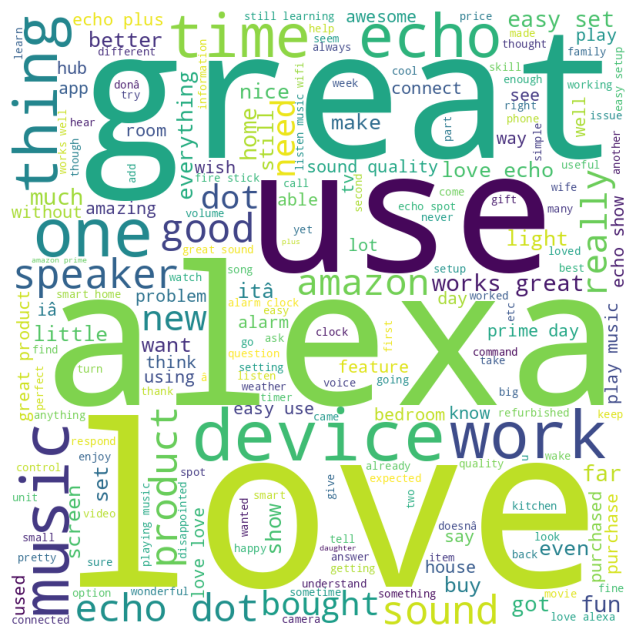

In [13]:
# Combine all reviews into a single string
all_reviews = " ".join(data["clean_review"])

# Generate word cloud
wordcloud = WordCloud(width=800, height=800, background_color='white', min_font_size=10).generate(all_reviews)

# Plot word cloud
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()


In [14]:
# If 'user_sentiment' is not in the dataset, add a mock sentiment column for testing
if "user_sentiment" not in data.columns:
    # Add a column with sample sentiment labels (e.g., 'positive', 'negative', 'neutral')
    sentiments = ["positive", "negative", "neutral"]  # Define sentiment options
    data["user_sentiment"] = (sentiments * ((len(data) // len(sentiments)) + 1))[:len(data)]  # Ensure exact length

# Encode target labels
encoder = LabelEncoder()
data["encoded_sentiment"] = encoder.fit_transform(data["user_sentiment"])

# Display the dataset with encoded sentiments
print(data.head(10))



   ï»¿rating       date             variation  \
0          5  31-Jul-18      Charcoal Fabric    
1          5  31-Jul-18      Charcoal Fabric    
2          4  31-Jul-18        Walnut Finish    
3          5  31-Jul-18      Charcoal Fabric    
4          5  31-Jul-18      Charcoal Fabric    
5          5  31-Jul-18  Heather Gray Fabric    
6          3  31-Jul-18     Sandstone Fabric    
7          5  31-Jul-18      Charcoal Fabric    
8          5  30-Jul-18  Heather Gray Fabric    
9          5  30-Jul-18  Heather Gray Fabric    

                                    verified_reviews  feedback  \
0                                      Love my Echo!         1   
1                                          Loved it!         1   
2  Sometimes while playing a game, you can answer...         1   
3  I have had a lot of fun with this thing. My 4 ...         1   
4                                              Music         1   
5  I received the echo as a gift. I needed anothe...         1  

In [15]:
# Tokenize and vectorize reviews
tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")
tokenizer.fit_on_texts(data["clean_review"])
X = tokenizer.texts_to_sequences(data["clean_review"])
X = pad_sequences(X, padding="post")

# Display tokenized reviews
print(X[:5])


[[   2    3    0 ...    0    0    0]
 [ 180    0    0 ...    0    0    0]
 [ 191  103 1702 ...    0    0    0]
 [  93   38   47 ...    0    0    0]
 [   6    0    0 ...    0    0    0]]


In [16]:
# One-hot encode the labels
Y = to_categorical(data["encoded_sentiment"])

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)


In [54]:
model = Sequential([
       Embedding(input_dim=5000, output_dim=120),  # Remove input_length
       SpatialDropout1D(0.4),
       LSTM(176, dropout=0.2, recurrent_dropout=0.2),
       Dense(2, activation="softmax")
   ])

# Compile the model
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

model.build(input_shape=(None, X.shape[1]))  # Build the model
model.summary()


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)              │ (None, 284, 120)            │         600,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d_4                  │ (None, 284, 120)            │               0 │
│ (SpatialDropout1D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ (None, 176)                 │         209,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 2)                   │             354 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 809,442 (3.09 MB)

 Trainable params: 809,442 (3.09 MB)

 Non-trainable params: 0 (0.00 B)

In [55]:
# Features
n_features = 41
# Create an instance of the Sequential class
model = Sequential() # This line is changed
# Embedding Layer
model.add(Embedding(500, 120, input_shape=(n_features,)))
# SpatialDropout1D
model.add(SpatialDropout1D(0.4))
# LSTM Layer
model.add(LSTM(176, dropout=0.2, recurrent_dropout=0.2))
# Dense Layer
model.add(Dense(2, activation='softmax')) # This line is changed: from model-add to model.add
# Summary
model.summary()
# Compile
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# Fit


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_8 (Embedding)              │ (None, 41, 120)             │          60,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d_5                  │ (None, 41, 120)             │               0 │
│ (SpatialDropout1D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 176)                 │         209,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 2)                   │             354 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 269,442 (1.03 MB)

 Trainable params: 269,442 (1.03 MB)

 Non-trainable params: 0 (0.00 B)

In [56]:
print(y_train.shape)  # Verify the shape of y_train
print(data["encoded_sentiment"].nunique())  # Check the number of unique classes


(2519, 3)
3


In [57]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model = Sequential([
    Dense(128, activation="relu", input_dim=X_train.shape[1]),
    Dense(64, activation="relu"),
    Dense(3, activation="softmax")  # Ensure the output layer has 3 units
])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [58]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])


In [68]:
# Train the model
model.fit(X_train, y_train, epochs=25, batch_size=200, verbose="auto")


Epoch 1/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6609 - loss: 0.9335 
Epoch 2/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6652 - loss: 0.8552 
Epoch 3/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6646 - loss: 0.8494 
Epoch 4/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6496 - loss: 0.9801 
Epoch 5/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6805 - loss: 0.8286 
Epoch 6/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6778 - loss: 0.8287
Epoch 7/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6525 - loss: 0.9743
Epoch 8/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6789 - loss: 0.8498
Epoch 9/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6709 - loss: 0.8778
Epoch 10/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6768 - loss: 0.7931
Epoch 11/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6853 - loss: 0.7431
Epoch 12/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6787

In [69]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {accuracy:.3f}")


Test Accuracy: 0.356


In [70]:
# Predict sentiments on the test set
y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)

# Generate classification report
report = classification_report(y_true, y_pred, target_names=encoder.classes_)
print(report)


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
              precision    recall  f1-score   support

    negative       0.33      0.29      0.31       202
     neutral       0.35      0.28      0.31       201
    positive       0.37      0.48      0.42       227

    accuracy                           0.36       630
   macro avg       0.35      0.35      0.35       630
weighted avg       0.35      0.36      0.35       630



In [76]:
# Client program for sentiment prediction
def predict_sentiment(review):
    # Clean the review
    cleaned_review = clean_text(review)
    # Tokenize and pad the review
    tokenized_review = tokenizer.texts_to_sequences([cleaned_review])
    padded_review = pad_sequences(tokenized_review, maxlen=X.shape[1], padding="post")
    # Predict sentiment
    sentiment = model.predict(padded_review)
    predicted_class = np.argmax(sentiment)
    return encoder.inverse_transform([predicted_class])[0]

# Test the client program
user_review = input("Enter a review: ")
predicted_sentiment = predict_sentiment(user_review)
print(f"Predicted Sentiment: {predicted_sentiment}")


Enter a review: do not buy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Predicted Sentiment: negative


In [ ]:
# #Splitting the data into training and testing
# X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20)

# print("Number of samples for training [news]:{}\nNumber of sample for training [Labels]:{}".format(X_train.shape,y_train.shape))
# print("Number of samples for testing [news]:{}\nNumber of sample for testing [Labels]:{}".format(X_test.shape,y_test.shape))

In [ ]:
# # compile the model

# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'] )
# # fit the model
# model.fit(X_train,y_train,epochs=20, batch_size=32, verbose=2)

In [ ]:
# # Evaluate out model using the accuracy metric
# loss, acc = model.evaluate(X_test,y_test,verbose=0)
# print('Test Accuracy: %.3f' % acc)

In [ ]:
# # Evaluating the model
# sentiment_prediction = model.predict(X_test)
# predicted_inverse = np.argmax(sentiment_prediction,axis=1)
# y_test_inverse = np.argmax(y_test,axis=1)

In [ ]:
# target_name = ["Class {}".format(i) for i in range(3)]

# print(classification_report(y_test_inverse,predicted_inverse,target_names=target_name) )

              precision    recall  f1-score   support

     Class 0       0.50      0.35      0.41       122
     Class 1       0.72      0.85      0.78       565
     Class 2       0.58      0.45      0.51       282

    accuracy                           0.67       969
   macro avg       0.60      0.55      0.57       969
weighted avg       0.65      0.67      0.66       969

